In [2]:
import fsspec

fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('')

In [5]:
hrr_subhourly_member_files = fs_read.glob('s3://noaa-hrrr-bdp-pds/hrrr.20230715/conus/hrrr.t23z.wrfsubhf*.grib2')

files = sorted(['s3://'+f for f in hrr_subhourly_member_files])
print(f'Read {len(files)} HRRR files')

Read 19 HRRR files


In [7]:
import ujson
from gribberish.kerchunk import scan_gribberish

so = {"anon": True, "use_ssl": False}
json_dir = 'hrrr/'

def make_json_name(file_url, message_number): #create a unique name for each reference file
    date = file_url.split('/')[3].split('.')[1]
    name = file_url.split('/')[5].split('.')[0:3]
    return f'{json_dir}{date}_{name[0]}_{name[1]}_{name[2]}_message{message_number}.json'

def gen_json(file_url):
    out = scan_gribberish(file_url, storage_options=so, only_vars=['apcp', 'gust', 'prate', 'tmp', 'ugrd_UGRDhag_fcst', 'vgrd_VGRDhag_fcst'], skip=6) 
    for i, message in enumerate(out):
        out_file_name = make_json_name(file_url, i)  # get name
        with fs_write.open(out_file_name, "w") as f: 
            f.write(ujson.dumps(message)) # write to file

In [8]:
from dask.distributed import Client, progress

client = Client(processes=False)
futures = client.map(gen_json, files[1:5], retries=1)
progress(futures)

/Users/matthewiannucci/Developer/gribberish/python/examples/env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59698 instead
  warnings.warn(


VBox()

In [9]:
client.shutdown()

In [10]:
from kerchunk.combine import MultiZarrToZarr

reference_jsons = sorted(fs_write.ls(json_dir)) #get list of file names

print(f'Found {len(reference_jsons)} reference files')

# combine individual references into single consolidated reference
mzz = MultiZarrToZarr(reference_jsons,
                      concat_dims = ['time'],
                      identical_dims=['x', 'y', 'latitude', 'longitude', 'hag'])

d = mzz.translate()

with open(f'{json_dir}/hrrr_kerchunk.json', 'w') as f:
    f.write(ujson.dumps(d))

Found 24 reference files


In [3]:
import xarray as xr

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo=f'./hrrr/hrrr_kerchunk.json', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), chunks={'time': 1})
ds

<xarray.Dataset>
Dimensions:    (time: 12, y: 1059, x: 1799)
Coordinates:
    latitude   (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
  * time       (time) datetime64[s] 2023-07-15T23:00:00 ... 2023-07-16T02:30:00
  * x          (x) float64 -2.701e+06 -2.698e+06 ... 2.69e+06 2.693e+06
  * y          (y) float64 -1.581e+06 -1.578e+06 ... 1.59e+06 1.593e+06
Data variables:
    apcp       (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    gust       (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    prate      (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    tmp        (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    meta:     Generated with gribberishpy

In [4]:
import pyproj
to_xy = pyproj.Transformer.from_crs('epsg:4326', ds.prate.crs, always_xy=True).transform

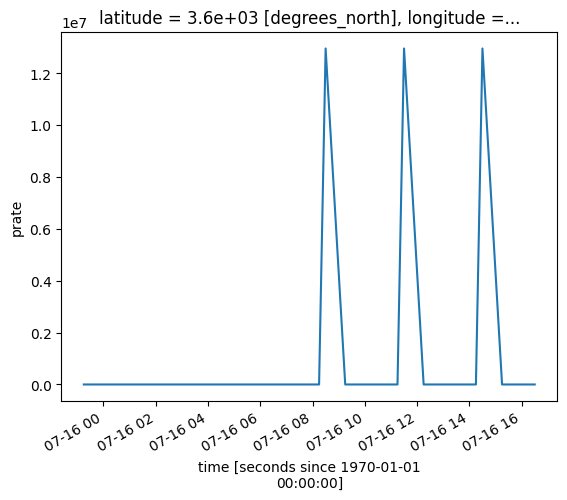

In [6]:
lat, lng = 41.42717976016072, -71.462122760827

x_sel, y_sel = to_xy(lng, lat)

selected = ds.prate.sel(x=x_sel, y=y_sel, method='nearest')
selected = selected * 3600 # convert from kg/m^2/s to mm/hr
selected.plot()